In [17]:
import torch 
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
device = 'cuda:0' if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [18]:
filepath = "train_all.csv"
train_data = pd.read_csv(filepath)
test_data = pd.read_csv("test.csv")

In [19]:
'''将train.csv and test.csv 中的数据转化为np.array，按照原格式81*735一行一行的存入数组中'''
def loaddata(data, rows, lines):#将每一行的各列的数据放入train_data_row中
    data_rows=[]
    for row in range(0,rows):
        data_row=[]
        for line in range(0,lines):
            data_row.append(data[str(line)][row]) #将每一行的各列的数据放入train_data_row中
        data_rows.append(data_row)
    return np.array(data_rows)

In [20]:
def normalizationdata(data):  #归一化
    range = np.max(data) - np.min(data)
    return (data - np.min(data)) / range

In [21]:
'''将训练数据和测试数据的每一行都装入train_data_rows'''
train_data_rows = loaddata(train_data, 111, 735)
#print(train_data_rows[0])
test_data_rows = loaddata(test_data, 111, 56)
type(test_data_rows)

numpy.ndarray

In [22]:
'''将数据归一化处理'''
train_data_rows_nor = normalizationdata(train_data_rows)
print(train_data_rows_nor.shape)
test_data_rows_nor = normalizationdata(test_data_rows)
#test_data_rows_nor[0]

(111, 735)


In [23]:
'''
不重叠的将每一行数据划分为输入输出对
根据不同的输入步长num_row，输出步长output_size,将分割出来的数据放入到data_rows中
data_rows=[训练数据(num_row)，训练数据的验证(长度为56)
输入的数据为归一化处理过后的训练集，以及输入步长'''
def input_size(data_nor, num_row, output_size):#输出为定长56，而输入长度可以改变，为num_rows
    train_data_rows = []
    test_data_rows = []

    for row in range(0,111):
        train_data_row = []
        test_data_row = []
        
        count = 0
        line = 0
        while count + num_row + output_size - 1 < 735:
            data_row_train = []
            data_row_test = []
            line = count

            while True:
                if count  < line+num_row:
                    data_row_train.append(data_nor[row][count]) #将每一行的各列的数据放入data_row_train中
                    count += 1

                elif count >= line+num_row and count<line+num_row+output_size:#如果count大于等于输入步长且小于输入加输出步长，则输入到data_row_test中
                    data_row_test.append(data_nor[row][count])
                    count += 1
                
                elif count == line+num_row+output_size: #如果输入输出步长加上起始位置超过最大列下标，则推出本行循环
                    break

            train_data_row.append(data_row_train)
            test_data_row.append(data_row_test)

        train_data_rows.append(train_data_row)
        test_data_rows.append(test_data_row)

    return np.array(train_data_rows), np.array(test_data_rows)
    

In [24]:
'''得到不同输入步长的训练集合,training_data_input_x的维度为(行数（111），每一行划分成了多少个训练样本/测试样本集合，输入步长)'''
training_data_input_56, train_data_output_56 = input_size(train_data_rows_nor, 56, 56)
print(training_data_input_56.shape)
print(train_data_output_56.shape)

training_data_input_112, train_data_output_112 = input_size(train_data_rows_nor, 112, 56)
print(training_data_input_112.shape)
print(train_data_output_112.shape)

training_data_input_679, train_data_output_679 = input_size(train_data_rows_nor, 679, 56)
print(training_data_input_679.shape)
print(train_data_output_679.shape)

(111, 6, 56)
(111, 6, 56)
(111, 4, 112)
(111, 4, 56)
(111, 1, 679)
(111, 1, 56)


In [25]:
'''将数据转化为tensor'''
input_56, output_56 = torch.tensor(training_data_input_56), torch.tensor(train_data_output_56)
input_112, output_112 = torch.tensor(training_data_input_112), torch.tensor(train_data_output_112)
input_679, output_679 = torch.tensor(training_data_input_679), torch.tensor(train_data_output_679)


In [26]:
'''建立LSTM模型'''
class RNN(nn.Module):
    def __init__(self, input_size = 679):
        super(RNN,self).__init__()
        self.input_size = input_size

        self.lstm = nn.LSTM(input_size,32,2) #输入数据input_size个特征维度，32个隐藏层维度，4个LSTM串联，第二个LSTM接收第一个的计算结果
#两个特征维度表示输入序列中的inpuge_size个数字进模型，32个隐藏层维度说明输出为32个值，4个LSTM串联表示两个LSTM堆叠起来，上一个LSTM输出的值输入到下一个LSTM中 

        self.linear = nn.Linear(32,56) #线性拟合，接收数据的维度为32，输出数据的维度为56
#线性层，即多层感知机那样的层，将LSTM6个隐藏层的输出值输入到线性层中，然后输出输出步长个值，如果要对未来56天的数据进行预测，则应该为(32,56)

    def forward(self,x):
        x1,_ = self.lstm(x)
        #https://zhuanlan.zhihu.com/p/39191116
        #lstm的输出有两个，output和(hn,cn)
        #output的维度未a，batch_size, 隐藏单元个数
        #output是最后一层lstm隐藏层的输出
        # hn,cn是所有层最后一个隐藏元和记忆元的输出
        a,b,c = x1.shape
        out = self.linear(x1.view(-1,c))
        #将lstm输出的输出步长(56)个值输入到线性层中

        #view(-1,c)函数将其自动调整为x1.shape[0]*c = 初始的所有元素个数
        out1 = out.view(a,b,-1)
        #线性层的输出调整为有多少个数据以及batch，最后一个维度(-1)是输出步长大小
        
        return out1

'''测试train中prediction的输入为啥会多一个维度
train_input = torch.tensor(train_data_rows_nor).view(train_data_rows_nor.shape[0], 1, -1)
print(train_input.shape)
a = train_input[:, :, [range(735-679, 735)]].view(train_data_rows_nor.shape[0], 1, -1)
print(a.shape)
#a.shape
#prediction = model(train_input[:, :, [range(735-input_size, 735)]]).view(train_input.shape[0], 1, -1)
'''


In [27]:
train_input = torch.tensor(train_data_rows_nor).view(train_data_rows_nor.shape[0], 1, -1)
print(train_input.shape)
a = train_input[:, :, [range(735-679, 735)]].view(train_data_rows_nor.shape[0], 1, -1)
print(a.shape)
#a.shape
#prediction = model(train_input[:, :, [range(735-input_size, 735)]]).view(train_input.shape[0], 1, -1)

torch.Size([111, 1, 735])
torch.Size([111, 1, 679])


以上是对数据进行的处理

In [28]:
'''训练函数
输入：已经处理好的每行的数据输入输出对，归一化的训练数据：用于利用训练后的模型输入每行最后输入长度个数据得到预测结果；后面的不用赘述'''
def train(training_datas, label_datas, train_data_rows_nor, model, optimizer, loss_fuc, input_size, epochs = 500):
    losses = [] 
    iter = []

    for epoch in range(epochs):
        #整体的数据输入进去，然后模型自己通过SGD进行优化
        #所以一次循环就是对所有数据进行训练一次，即一个epoch
        X_datas = training_datas.type(torch.float32).to(device)
        Y_datas = label_datas.type(torch.float32).to(device)
        #因为输入的数据已经是包含三个维度的了，并且每一行的输入输出对刚好可以成为batch_size所以不用改变形状了

        pred = model(X_datas)
        loss = loss_fuc(pred, Y_datas)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            losses.append(loss.item())
            print("the loss of epoch：   " +str(epoch) + "   is: "+ str(loss.item()))
            iter.append(epoch)
    
    #训练完毕
    
    train_input = torch.tensor(train_data_rows_nor).view(train_data_rows_nor.shape[0], 1, -1).to(device)
    temp = train_input[:, :, [range(735-input_size, 735)]].view(train_data_rows_nor.shape[0], 1, -1)#不知道为啥不加view会抽风的增加一个维度
    prediction = model(temp.type(torch.float32)) #prediction为利用模型利用训练数据每行最后的输入长度个的值为输入，输出56个输出作为prediction
    #预测值为X_datas的第2个维度的最后一个输入
    #注意这里要统一数据类型为float32


    plt.title("loss of epoch per 100————"+str(loss_fuc)+ ","+ str(epochs)+ "epochs,"+"input size is:"+str(input_size))
    plt.xlabel("loss per 100")
    plt.ylabel("LOSS")
    plt.plot(iter, losses)
    plt.show()

    return prediction.to('cpu')
    #prediction为利用训练集数据中最后输入长度个输入到模型得到的结果

In [29]:
'''sMAPE精确度指标'''
def sMAPE(pred, y):
    
    n = pred.shape[0] * pred.shape[1] 
    sum = abs(pred-y)/(abs(pred+y)/2)
    acc = torch.sum(sum)/n #将所有元素相加
    return acc*100

'''将归一化的数据恢复成原本的数据'''
def reverse_normalizationdata(data,max,min):
    range = max - min
    return torch.mul(data, range)+min

In [30]:
'''计算测试集的sMAPE指标
输入未归一化的训练数据，预测的prediction，未归一化的测试数据以及输入长度'''
def cal_sMAPE_train(train_data_rows, prediction, test_data_rows, input_size):

    train_max = np.max(train_data_rows, axis=1)  #axis=1表示求各行的最大值
    train_min = np.min(train_data_rows, axis=1)

    train_max_ts = torch.tensor(train_max).view(train_max.shape[0],1,-1)
    train_min_ts = torch.tensor(train_min).view(train_max.shape[0],1,-1)
    #上面求得了符合格式的最大值和最小值
    pred = reverse_normalizationdata(prediction, train_max_ts, train_min_ts)#将prediction按照训练集每行相应的最大最小值反归一化
    y = torch.tensor(test_data_rows).view(prediction.shape[0], 1, -1)
    #将未归一化的测试集数据转换成和prediction一样的形状


    acc = sMAPE(pred.view(1,-1), y.view(1,-1))

    print("输入步长为"+str(input_size)+"的测试集上的sMAPE指标："+str(acc.item())) #item可以只保留数字

    return acc

the loss of epoch：   0   is: 0.0467258095741272
the loss of epoch：   100   is: 0.0424092672765255
the loss of epoch：   200   is: 0.03869815170764923
the loss of epoch：   300   is: 0.035447996109724045
the loss of epoch：   400   is: 0.03256887197494507
the loss of epoch：   500   is: 0.029999462887644768
the loss of epoch：   600   is: 0.027694981545209885
the loss of epoch：   700   is: 0.02562115155160427
the loss of epoch：   800   is: 0.023750800639390945
the loss of epoch：   900   is: 0.0220617838203907
the loss of epoch：   1000   is: 0.020535625517368317
the loss of epoch：   1100   is: 0.019156550988554955
the loss of epoch：   1200   is: 0.01791086606681347
the loss of epoch：   1300   is: 0.016786472871899605
the loss of epoch：   1400   is: 0.015772534534335136
the loss of epoch：   1500   is: 0.014859247952699661
the loss of epoch：   1600   is: 0.014037667773663998
the loss of epoch：   1700   is: 0.013299577869474888
the loss of epoch：   1800   is: 0.012637409381568432
the loss of epo

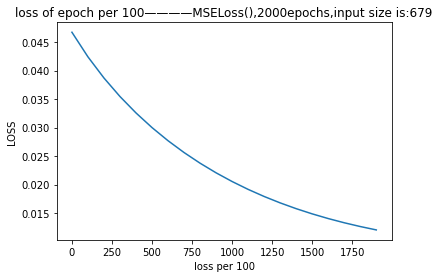

输入步长为679的测试集上的sMAPE指标：86.6617799644018


In [31]:
'''初始化模型，定义损失函数和优化方法'''
lstm_679 = RNN(679).to(device)
optimizer_adam = torch.optim.Adam(lstm_679.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_679.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

'''训练模型，根据训练集的前679个数据得到预测值，然后计算训练集的sMAPE'''
prediction = train(input_679, output_679, train_data_rows_nor, lstm_679, optimizer_sgd, loss_mse, 679, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, test_data_rows, 679)

the loss of epoch：   0   is: 0.21407228708267212
the loss of epoch：   100   is: 0.1908847689628601
the loss of epoch：   200   is: 0.16936959326267242
the loss of epoch：   300   is: 0.14922966063022614
the loss of epoch：   400   is: 0.13053473830223083
the loss of epoch：   500   is: 0.11341286450624466
the loss of epoch：   600   is: 0.09836035221815109
the loss of epoch：   700   is: 0.08584792912006378
the loss of epoch：   800   is: 0.07614917308092117
the loss of epoch：   900   is: 0.06913886964321136
the loss of epoch：   1000   is: 0.06468422710895538
the loss of epoch：   1100   is: 0.062138862907886505
the loss of epoch：   1200   is: 0.06060684099793434
the loss of epoch：   1300   is: 0.059813834726810455
the loss of epoch：   1400   is: 0.059412043541669846
the loss of epoch：   1500   is: 0.05922804772853851
the loss of epoch：   1600   is: 0.05911271274089813
the loss of epoch：   1700   is: 0.05903666839003563
the loss of epoch：   1800   is: 0.05897567793726921
the loss of epoch：   1

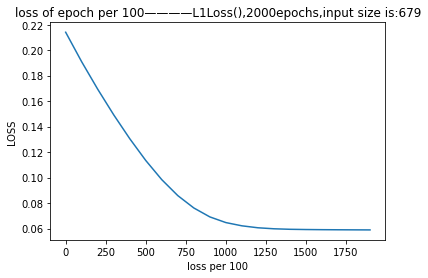

输入步长为679的测试集上的sMAPE指标：67.13235821515053


In [32]:
'''679——mAE——sgd'''
lstm_679 = RNN(679).to(device)
optimizer_adam = torch.optim.Adam(lstm_679.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_679.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

prediction = train(input_679, output_679, train_data_rows_nor, lstm_679, optimizer_sgd, loss_mae, 679, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, test_data_rows, 679)

the loss of epoch：   0   is: 0.06470009684562683
the loss of epoch：   100   is: 0.005426535848528147
the loss of epoch：   200   is: 0.0031366203911602497
the loss of epoch：   300   is: 0.002830527490004897
the loss of epoch：   400   is: 0.0027722434606403112
the loss of epoch：   500   is: 0.0027511590160429478
the loss of epoch：   600   is: 0.002740877214819193
the loss of epoch：   700   is: 0.0027353742625564337
the loss of epoch：   800   is: 0.002731441054493189
the loss of epoch：   900   is: 0.002728264546021819
the loss of epoch：   1000   is: 0.0027299290522933006
the loss of epoch：   1100   is: 0.0027222565840929747
the loss of epoch：   1200   is: 0.002720193937420845
the loss of epoch：   1300   is: 0.0027203387580811977
the loss of epoch：   1400   is: 0.002715436043217778
the loss of epoch：   1500   is: 0.002713809721171856
the loss of epoch：   1600   is: 0.0027124134358018637
the loss of epoch：   1700   is: 0.002711409004405141
the loss of epoch：   1800   is: 0.00270997779443860

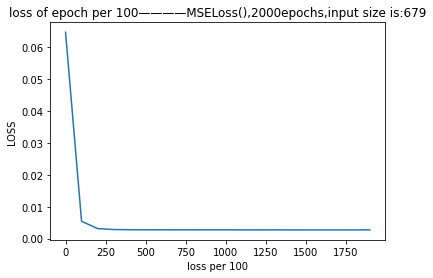

输入步长为679的测试集上的sMAPE指标：64.40635835380286


In [33]:
'''679——msE——adam'''
lstm_679 = RNN(679).to(device)
optimizer_adam = torch.optim.Adam(lstm_679.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
optimizer_sgd = torch.optim.SGD(lstm_679.parameters(),lr=1e-2)
loss_mae = nn.L1Loss()
loss_mse = nn.MSELoss()

prediction = train(input_679, output_679, train_data_rows_nor, lstm_679, optimizer_adam, loss_mse, 679, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, test_data_rows, 679)

the loss of epoch：   0   is: 0.05660563334822655
the loss of epoch：   100   is: 0.05173879861831665
the loss of epoch：   200   is: 0.04741738736629486
the loss of epoch：   300   is: 0.04355982318520546
the loss of epoch：   400   is: 0.04010118916630745
the loss of epoch：   500   is: 0.03698910400271416
the loss of epoch：   600   is: 0.03418080136179924
the loss of epoch：   700   is: 0.03164089843630791
the loss of epoch：   800   is: 0.02933976612985134
the loss of epoch：   900   is: 0.02725229226052761
the loss of epoch：   1000   is: 0.025356965139508247
the loss of epoch：   1100   is: 0.0236351378262043
the loss of epoch：   1200   is: 0.02207050658762455
the loss of epoch：   1300   is: 0.020648663863539696
the loss of epoch：   1400   is: 0.01935679465532303
the loss of epoch：   1500   is: 0.018183406442403793
the loss of epoch：   1600   is: 0.017118126153945923
the loss of epoch：   1700   is: 0.016151556745171547
the loss of epoch：   1800   is: 0.015275128185749054
the loss of epoch： 

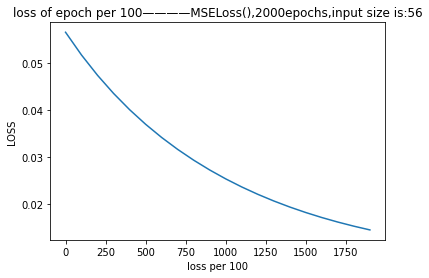

输入步长为56的测试集上的sMAPE指标：98.57705966903788


In [34]:
'''输入步长56，sgd优化方法，mse顺势函数'''
lstm_56 = RNN(56).to(device)
optimizer_sgd = torch.optim.SGD(lstm_56.parameters(),lr=1e-2)
optimizer_adam = torch.optim.Adam(lstm_56.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
prediction = train(input_56, output_56, train_data_rows_nor, lstm_56, optimizer_sgd, loss_mse, 56, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, test_data_rows, 56)

the loss of epoch：   0   is: 0.20194579660892487
the loss of epoch：   100   is: 0.05830658972263336
the loss of epoch：   200   is: 0.0432191863656044
the loss of epoch：   300   is: 0.03710192069411278
the loss of epoch：   400   is: 0.03661041334271431
the loss of epoch：   500   is: 0.03638476878404617
the loss of epoch：   600   is: 0.03616611286997795
the loss of epoch：   700   is: 0.03605721890926361
the loss of epoch：   800   is: 0.03595923259854317
the loss of epoch：   900   is: 0.0358157753944397
the loss of epoch：   1000   is: 0.03571270406246185
the loss of epoch：   1100   is: 0.03564361110329628
the loss of epoch：   1200   is: 0.035564716905355453
the loss of epoch：   1300   is: 0.035513825714588165
the loss of epoch：   1400   is: 0.03535524383187294
the loss of epoch：   1500   is: 0.035178713500499725
the loss of epoch：   1600   is: 0.03480412811040878
the loss of epoch：   1700   is: 0.03401423990726471
the loss of epoch：   1800   is: 0.03360496833920479
the loss of epoch：   19

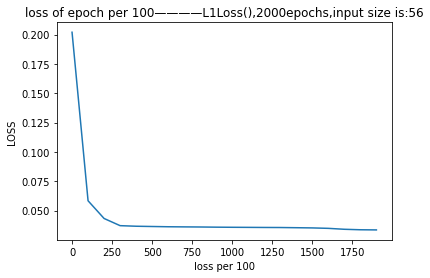

输入步长为56的测试集上的sMAPE指标：67.26093621614217


In [35]:
'''输入步长56，adam优化方法，mae损失函数'''
lstm_56 = RNN(56).to(device)
optimizer_adam = torch.optim.Adam(lstm_56.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
prediction = train(input_56, output_56, train_data_rows_nor, lstm_56, optimizer_adam, loss_mae, 56, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, test_data_rows, 56)

the loss of epoch：   0   is: 0.05839239060878754
the loss of epoch：   100   is: 0.007466813549399376
the loss of epoch：   200   is: 0.00695837615057826
the loss of epoch：   300   is: 0.0061722700484097
the loss of epoch：   400   is: 0.004876608494669199
the loss of epoch：   500   is: 0.004449669271707535
the loss of epoch：   600   is: 0.004372679628431797
the loss of epoch：   700   is: 0.0043427832424640656
the loss of epoch：   800   is: 0.004327302798628807
the loss of epoch：   900   is: 0.004316828679293394
the loss of epoch：   1000   is: 0.004309951793402433
the loss of epoch：   1100   is: 0.004305017646402121
the loss of epoch：   1200   is: 0.004300288390368223
the loss of epoch：   1300   is: 0.004297050181776285
the loss of epoch：   1400   is: 0.004294025711715221
the loss of epoch：   1500   is: 0.004293256904929876
the loss of epoch：   1600   is: 0.004290343727916479
the loss of epoch：   1700   is: 0.004287336952984333
the loss of epoch：   1800   is: 0.004284168127924204
the loss

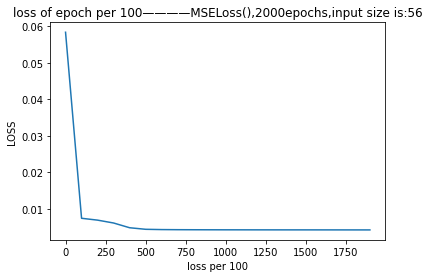

输入步长为56的测试集上的sMAPE指标：62.97904408001948


In [36]:
'''输入步长56，adam优化方法，mse损失函数'''
lstm_56 = RNN(56).to(device)
optimizer_adam = torch.optim.Adam(lstm_56.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
prediction = train(input_56, output_56, train_data_rows_nor, lstm_56, optimizer_adam, loss_mse, 56, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, test_data_rows, 56)

the loss of epoch：   0   is: 0.06009206175804138
the loss of epoch：   100   is: 0.007737183012068272
the loss of epoch：   200   is: 0.006733417045325041
the loss of epoch：   300   is: 0.005285631399601698
the loss of epoch：   400   is: 0.004817381035536528
the loss of epoch：   500   is: 0.0046587977558374405
the loss of epoch：   600   is: 0.004344901069998741
the loss of epoch：   700   is: 0.00352476560510695
the loss of epoch：   800   is: 0.0033374717459082603
the loss of epoch：   900   is: 0.0032973482739180326
the loss of epoch：   1000   is: 0.0032924781553447247
the loss of epoch：   1100   is: 0.0032881763763725758
the loss of epoch：   1200   is: 0.0032835863530635834
the loss of epoch：   1300   is: 0.0032787700183689594
the loss of epoch：   1400   is: 0.0032743585761636496
the loss of epoch：   1500   is: 0.0032713066320866346
the loss of epoch：   1600   is: 0.0032692330423742533
the loss of epoch：   1700   is: 0.003269185544922948
the loss of epoch：   1800   is: 0.0032697275746613

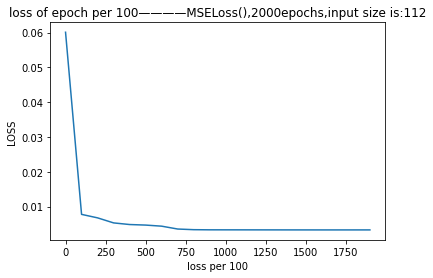

输入步长为112的测试集上的sMAPE指标：64.28724662787283


In [37]:
'''输入步长112，adam优化方法，mse损失函数'''
lstm_112 = RNN(112).to(device)
optimizer_adam = torch.optim.Adam(lstm_112.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
prediction = train(input_112, output_112, train_data_rows_nor, lstm_112, optimizer_adam, loss_mse, 112, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, test_data_rows, 112)

the loss of epoch：   0   is: 0.2161702811717987
the loss of epoch：   100   is: 0.053579460829496384
the loss of epoch：   200   is: 0.03897027671337128
the loss of epoch：   300   is: 0.036856912076473236
the loss of epoch：   400   is: 0.03609353303909302
the loss of epoch：   500   is: 0.035701215267181396
the loss of epoch：   600   is: 0.03531794250011444
the loss of epoch：   700   is: 0.03486381843686104
the loss of epoch：   800   is: 0.03424103558063507
the loss of epoch：   900   is: 0.033275168389081955
the loss of epoch：   1000   is: 0.032694846391677856
the loss of epoch：   1100   is: 0.03256398066878319
the loss of epoch：   1200   is: 0.03235458955168724
the loss of epoch：   1300   is: 0.032253313809633255
the loss of epoch：   1400   is: 0.03224032372236252
the loss of epoch：   1500   is: 0.03211818262934685
the loss of epoch：   1600   is: 0.03209256753325462
the loss of epoch：   1700   is: 0.03200651332736015
the loss of epoch：   1800   is: 0.03190885856747627
the loss of epoch： 

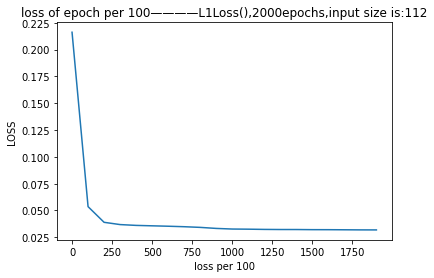

输入步长为112的测试集上的sMAPE指标：64.4692308586076


In [38]:
'''输入步长56，adam优化方法，mae损失函数'''
lstm_112 = RNN(112).to(device)
optimizer_adam = torch.optim.Adam(lstm_112.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
prediction = train(input_112, output_112, train_data_rows_nor, lstm_112, optimizer_adam, loss_mae, 112, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, test_data_rows, 112)

the loss of epoch：   0   is: 0.055094510316848755
the loss of epoch：   100   is: 0.049528077244758606
the loss of epoch：   200   is: 0.04464849457144737
the loss of epoch：   300   is: 0.04035099595785141
the loss of epoch：   400   is: 0.036553673446178436
the loss of epoch：   500   is: 0.033191051334142685
the loss of epoch：   600   is: 0.0302096139639616
the loss of epoch：   700   is: 0.027564723044633865
the loss of epoch：   800   is: 0.02521844021975994
the loss of epoch：   900   is: 0.02313801646232605
the loss of epoch：   1000   is: 0.021294765174388885
the loss of epoch：   1100   is: 0.019663305953145027
the loss of epoch：   1200   is: 0.018220990896224976
the loss of epoch：   1300   is: 0.016947507858276367
the loss of epoch：   1400   is: 0.015824560075998306
the loss of epoch：   1500   is: 0.014835651032626629
the loss of epoch：   1600   is: 0.013965890742838383
the loss of epoch：   1700   is: 0.013201853260397911
the loss of epoch：   1800   is: 0.012531453743577003
the loss of

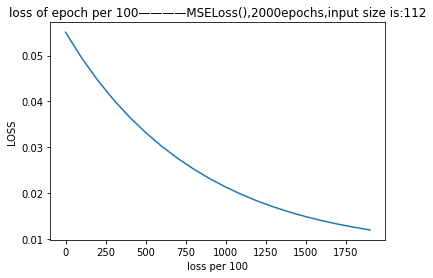

输入步长为112的测试集上的sMAPE指标：87.02663678375423


In [39]:
'''输入步长112，sgd优化方法，mse损失函数'''
lstm_112 = RNN(112).to(device)
optimizer_sgd = torch.optim.SGD(lstm_112.parameters(),lr=1e-2)
optimizer_adam = torch.optim.Adam(lstm_112.parameters(),lr=0.001,betas=(0.9, 0.999),eps=1e-08,weight_decay=0.0003,amsgrad=False)
prediction = train(input_112, output_112, train_data_rows_nor, lstm_112, optimizer_sgd, loss_mse, 112, 2000)
acc = cal_sMAPE_train(train_data_rows, prediction, test_data_rows, 112)